# Test DECiSION

## Import packages

In [1]:
import DECiSION_settings as settings
from thesis_common import read_preprocess_image, read_preprocess_groundtruth,\
    convert_img_to_pred, convert_pred_to_img, convert_img_to_pred_flatten,\
    convert_pred_to_img_flatten, group_images, show_image, create_hdf5_db

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_NN

import os, cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_softmax_ep100.model"

## Convert test data to HDF5

In [3]:
def perform_hdf5_conversion(settings):
    # Prepare the path to the training images and ground truths
    img_exts = ".jpg"
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    test_imgs = sorted(list(list_images(basePath=test_path, validExts=img_exts)))

    # Create the HDF5 data sets
    output_paths = []

    # Test images (no ground truths available, no need to split). The assumption is only
    # relevant images are placed in the test folder, i.e. the pipeline will not exclude
    # any slices
    output_paths.append(create_hdf5_db(test_imgs, "test", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    return output_paths

output_paths = perform_hdf5_conversion(settings)

Creating HDF5 database N/A% |                                  | ETA:  --:--:--

../data/MSC8002/test/test_imgs.h5


Creating HDF5 database 100% |###################################| Time: 0:00:03


## Load data

In [4]:
# Load the test images including ground truth images (the latter will not be used during inference,
# only for visualisation)
if settings.IS_DEVELOPMENT:
    print("--- Pre-processing TRAINING images")
    test_imgs = read_preprocess_image("../data/MSC8002/training/train_imgs.h5", settings.HDF5_KEY)
    test_ground_truths = read_preprocess_groundtruth("../data/MSC8002/training/train_masks.h5", settings.HDF5_KEY)
else:
    print("--- Pre-processing test images")
    test_imgs = read_preprocess_image(output_paths[0], settings.HDF5_KEY)

--- Pre-processing TRAINING images
Loading image HDF5: ../data/MSC8002/training/train_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/train_masks.h5 with dtype = uint8



## Show one image to check

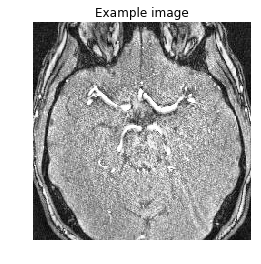

       Max image intensity: 0.5 - float32 - (9, 240, 240, 1)


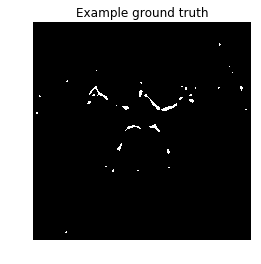

Max ground truth intensity: 255 - uint8 - (9, 240, 240, 1)


In [5]:
# Show an image plus its ground truth to check
IX = 0
show_image(np.squeeze(test_imgs[IX]), 'Example image')

print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[IX]), test_imgs.dtype, test_imgs.shape))
if settings.IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[IX]), 'Example ground truth')
    print("Max ground truth intensity: {} - {} - {}".format(np.max(test_ground_truths[IX]), test_ground_truths.dtype, test_ground_truths.shape))

## Only predict for a few images

In [ ]:
# Only predict for some images
# MAX_IMAGES = int((settings.SLICE_END - settings.SLICE_START) * (1 - settings.TRN_TRAIN_VAL_SPLIT))
# PRED_IX = range(0, MAX_IMAGES)
# test_imgs = test_imgs[[PRED_IX]]
# if settings.IS_DEVELOPMENT:
#     test_ground_truths = test_ground_truths[[PRED_IX]]

## Load the trained model

In [6]:
# Create the UNet model and load its saved weights
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)
model = unet.build_model_softmax()
# model = unet.build_model_sigmoid()
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Make predictions

In [7]:
# Make predictions
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

## Convert predictions

In [10]:
# Convert predictions to images
predictions = convert_pred_to_img(predictions, settings.TRN_PRED_THRESHOLD)

Elapsed time: 0.012057065963745117


## Show predictions

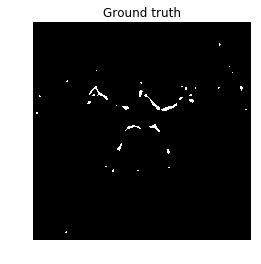

gr truth max 255 type uint8


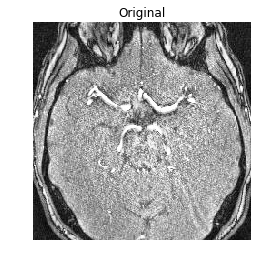

original 0.5 type float32


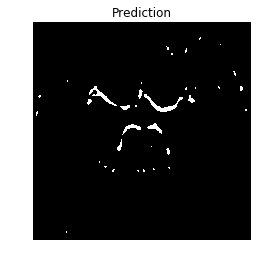

prediction 255 type uint8



In [11]:
MAX_IMAGES = 10
if settings.IS_DEVELOPMENT:
    tmp_img = test_ground_truths[0]
    show_image(np.squeeze(tmp_img), 'Ground truth')
    print("gr truth max {} type {}".format(np.max(tmp_img), tmp_img.dtype))

    tmp_img = test_imgs[0]
    show_image(np.squeeze(tmp_img), 'Original')
    print("original {} type {}".format(np.max(tmp_img), tmp_img.dtype))

    tmp_img = predictions[0]
    show_image(np.squeeze(tmp_img), 'Prediction')
    print("prediction {} type {}".format(np.max(tmp_img), tmp_img.dtype))

if settings.IS_DEVELOPMENT:
    group_images(test_ground_truths[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_"+unet.title+"_grp_originals")
group_images(test_imgs[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_images")
group_images(predictions[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_predictions")

print("")